In [12]:
%matplotlib inline

import re
import glob
import math
import json
import pandas as pd
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, exists, isdir
from os import makedirs

In [13]:
with open("config.json", "r") as jsonfile:
    config = json.load(jsonfile)

In [14]:
def get_distance(ax, ay, bx, by):
    return ((ax - bx)**2 + (ay - by)**2) ** 0.5

def project_points(profile_csv, subpoints):
    subpoints_idx = []
    for subpoint in subpoints:

        dist1 = float("inf")
        dist2 = float("inf")
        for point in profile_csv.loc[:, ["x_geo", "y_geo", "no_point"]].values:
            d1 = get_distance(point[0], point[1], subpoint[1], subpoint[2])
            d2 = get_distance(point[0], point[1], subpoint[3], subpoint[4])
            if d1 < dist1:
                dist1 = d1
                idx1 = point[2]
            if d2 < dist2:
                dist2 = d2
                idx2 = point[2]                
        
        subpoints_idx.append([min([idx1, idx2]), max([idx1, idx2])])

    return subpoints_idx

In [17]:
def draw_profile_features(title, axlines, features, points, profile, begin_no, end_no, zoom=False, save=False, show=True):
    
    cut = profile[profile["id"] > 0]
    if len(cut) > 0:
        figures_path = config["figures"]["path"]
        
        first_no = cut.iloc[0]["no_point"]
        last_no = cut.iloc[-1]["no_point"]
        first_no = first_no if first_no > begin_no else begin_no
        last_no = last_no if last_no < end_no else end_no
 
        x_min = begin_no if not zoom else first_no - 10
        x_max = end_no if not zoom else last_no + 10
            
        plt.xlim((x_min, x_max))
        plt.ylim((min(profile.elevation) - 1, max(profile.elevation) + 10)) 
        plt.gca().set_aspect("equal")
        plt.title(f"{title}  {'[zoomed]' if zoom else ''}")
        plt.xlabel("point no")
        plt.grid(linestyle=":")

        for line in axlines:
            plt.axhline(y = line, color = "y", linestyle = "--")
            
        axlines=[3],
        
        for f in features:
            y = profile[f][begin_no:end_no].to_numpy()
            plt.plot(np.arange(begin_no, end_no), y, "--")            
            
            y1 = profile[f][first_no:last_no].to_numpy()
            plt.plot(np.arange(first_no, last_no), y1)    
         
            
        def plot_point(name, point, base, color, mark):
            if math.isnan(point):
                return
    
            point = point.astype(int)
            if point < len(y) and point > 0:
                # point
                plt.plot(point, y[point], f"{color}{mark}", label=f"{name}: {point}")

                # line
                l = max(y) / 4
                yy = y[point] + (max((l, 4)) * base/abs(base)) # + label_y
                plt.plot((point, point), (y[point], yy), f"{color}--")

                # label
                plt.annotate(point, (point, yy))

        if len(points) > 0:
            plot_point("M1_D_high", points["M1_D_high"].iloc[0], base=2, color="r", mark="o")
            plot_point("M2_D_high", points["M2_D_high"].iloc[0], base=2, color="y", mark="o")
            plot_point("M1_D_low", points["M1_D_low"].iloc[0], base=2, color="g", mark="o")
            plot_point("M2_D_low", points["M2_D_low"].iloc[0], base=2, color="b", mark="o")

        plt.legend()
            
        if save:
            if not exists(figures_path) or not isdir(figures_path):
                makedirs(figures_path)
            plt.savefig(join(figures_path, f"{title}.cut{'.zoom' if zoom else ''}.jpg"), bbox_inches="tight", pad_inches=1, dpi=300)

        if show:
            plt.show()      

        plt.close()

In [18]:
csv_results = pd.read_csv(config["csv"]["results"]["path"], encoding="utf-8", sep=config["csv"]["results"]["sep"], skipinitialspace=True)
id_list = csv_results.profile_id

In [19]:
profile_files = list(filter(lambda p: int(re.search("\d{1,4}", p)[0]) in id_list, natsorted(glob.glob(join(config["csv"]["profiles"]["path"], "*")))))

profiles = []
profile_names = []

for name in profile_files:
    profile_names.append(name)
    profiles.append(pd.read_csv(name, encoding="utf-8", sep=config["csv"]["profiles"]["sep"], skipinitialspace=True))

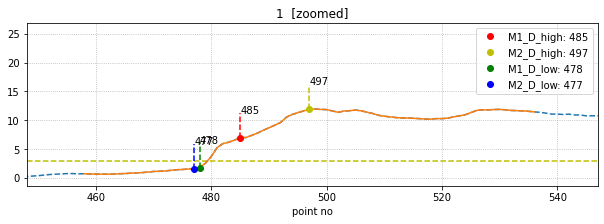

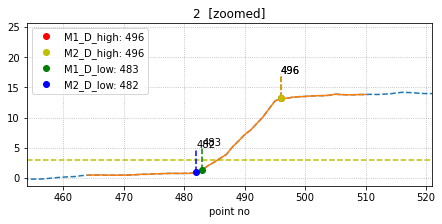

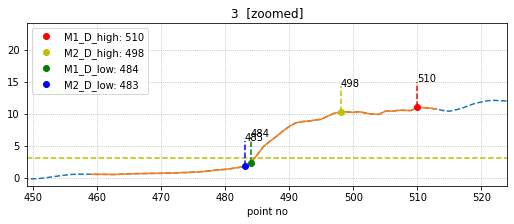

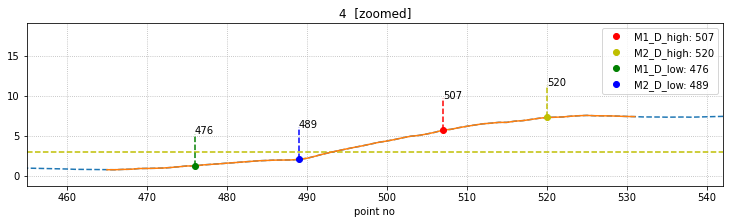

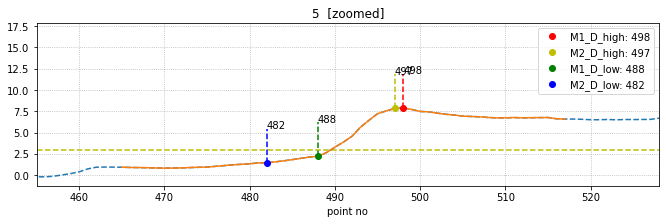

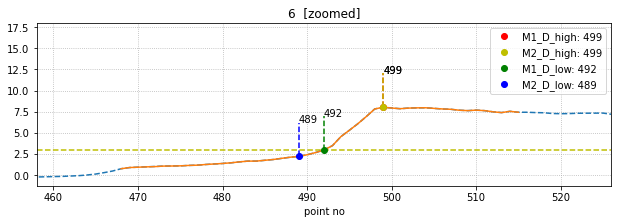

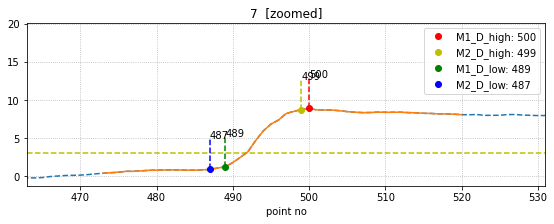

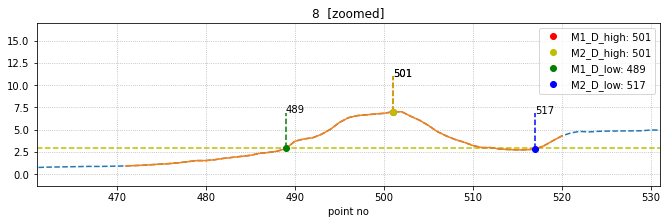

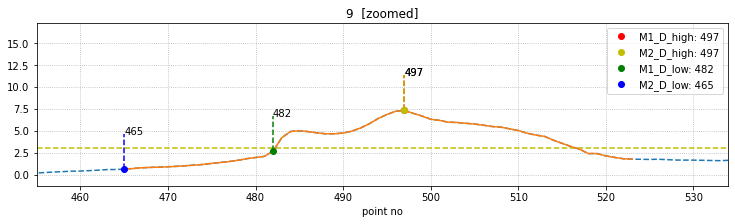

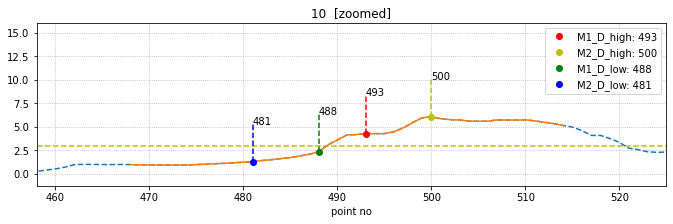

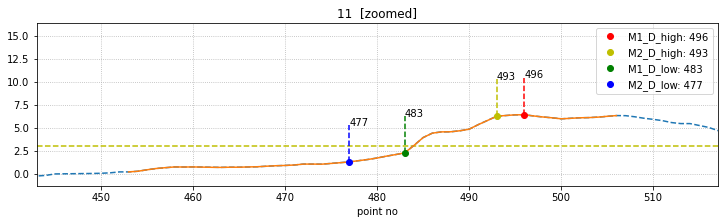

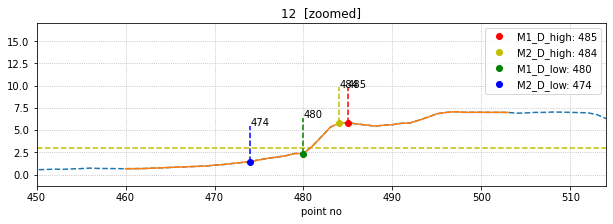

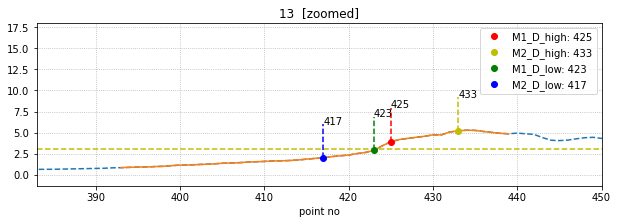

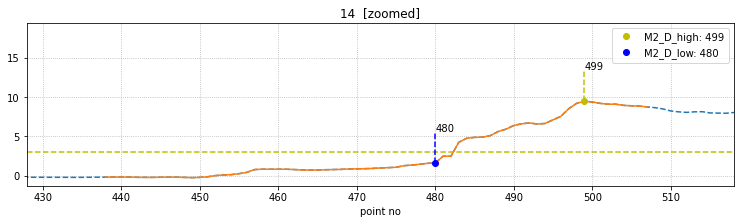

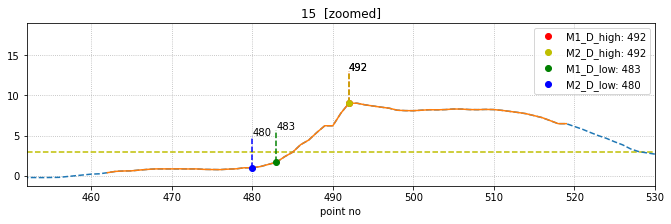

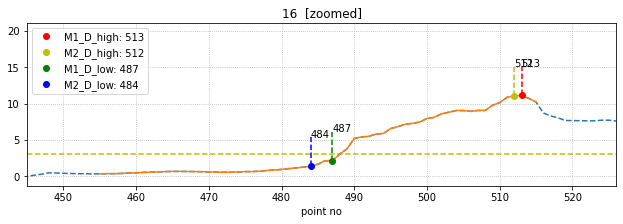

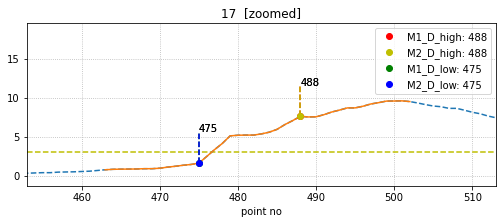

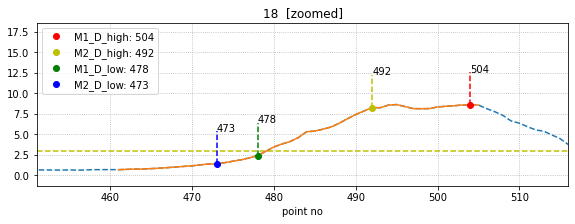

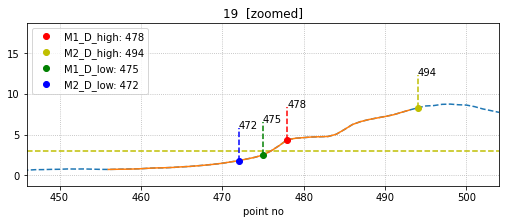

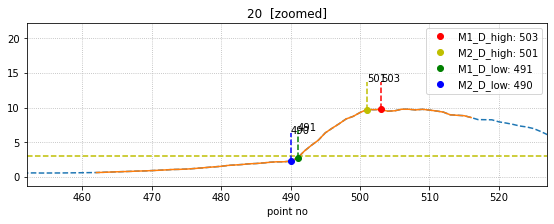

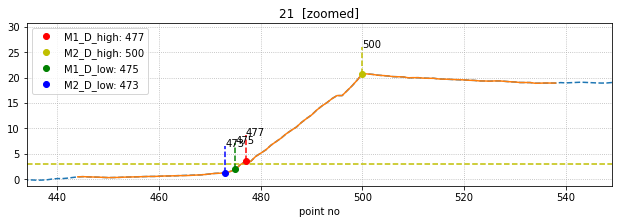

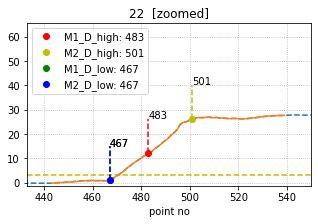

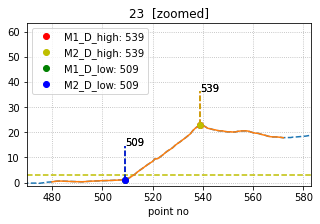

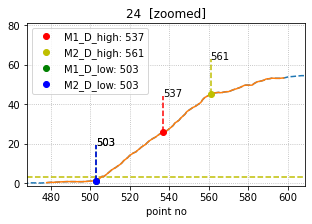

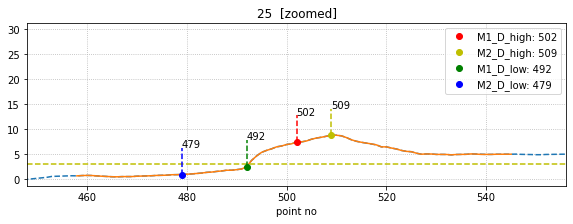

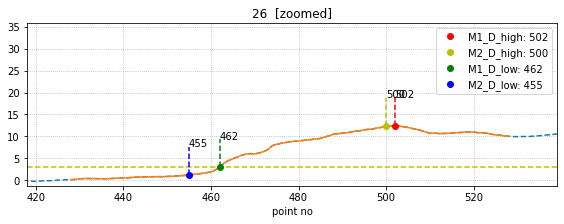

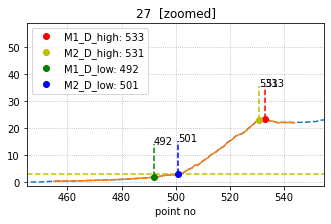

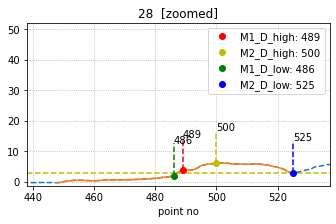

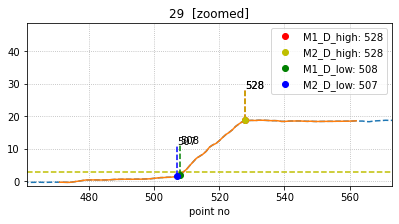

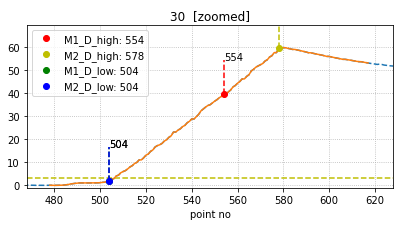

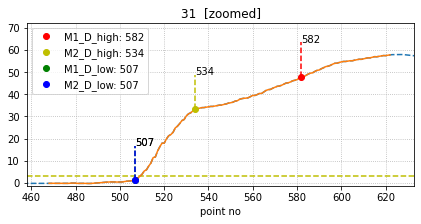

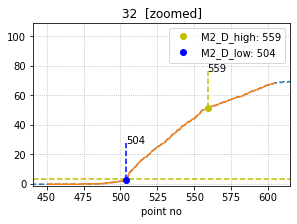

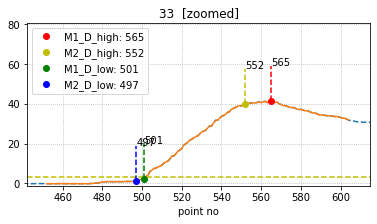

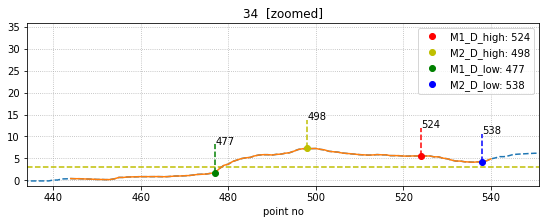

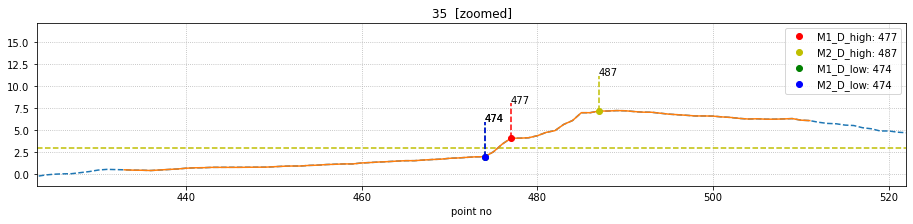

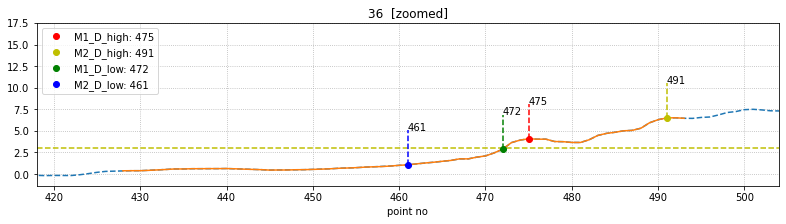

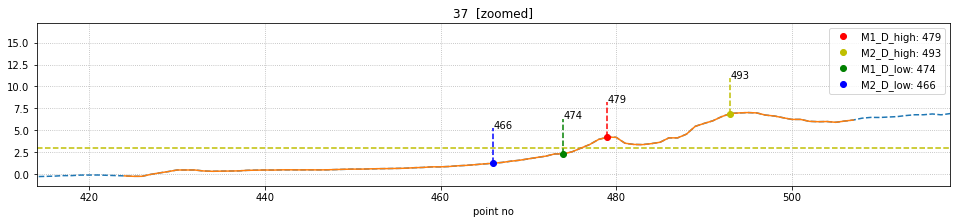

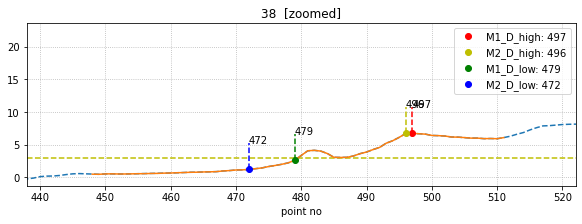

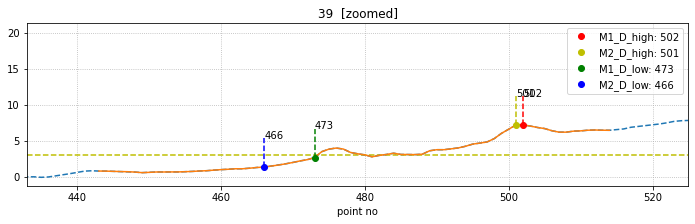

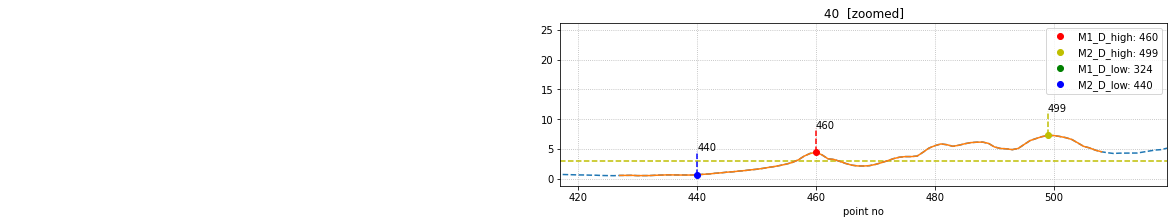

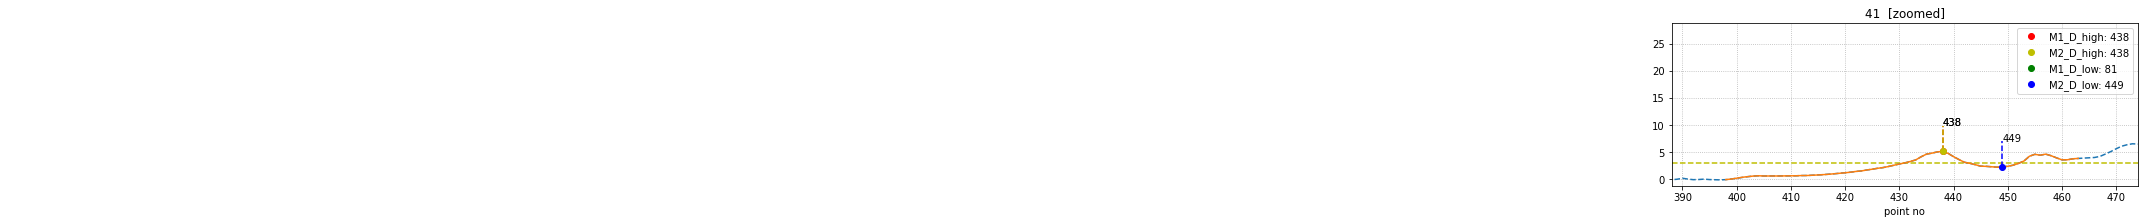

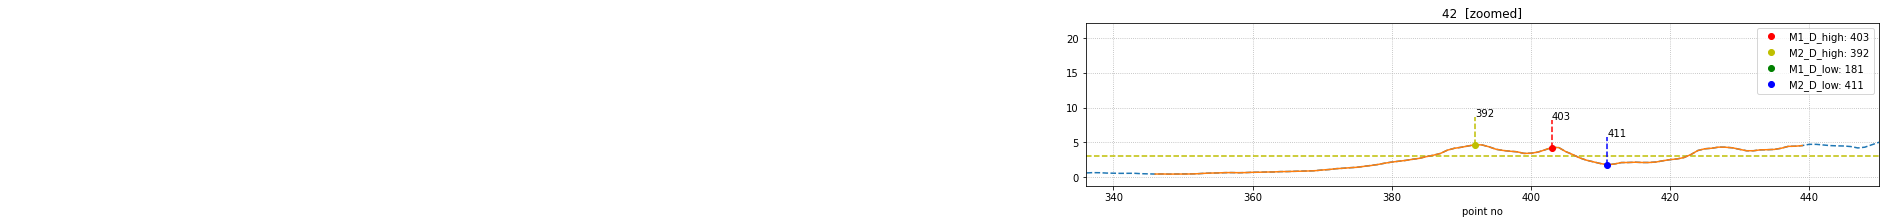

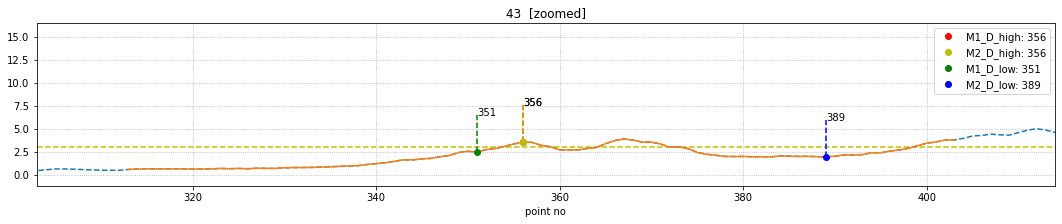

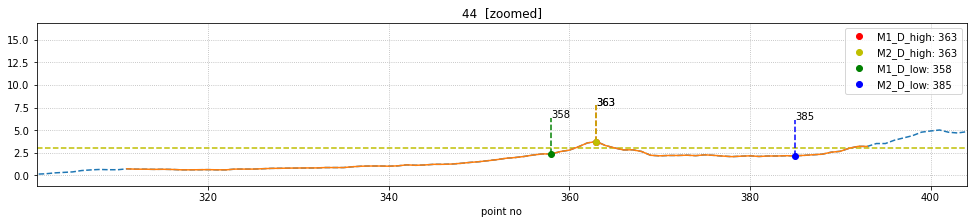

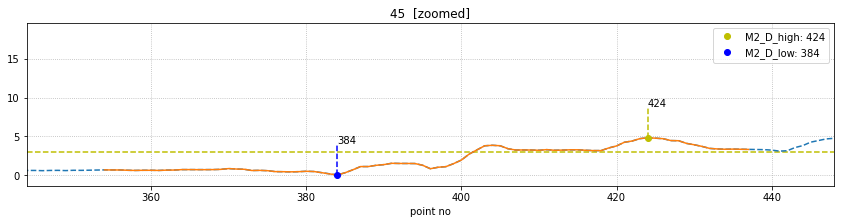

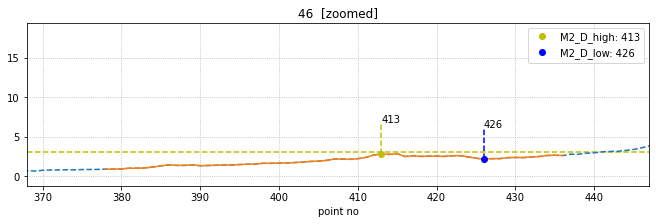

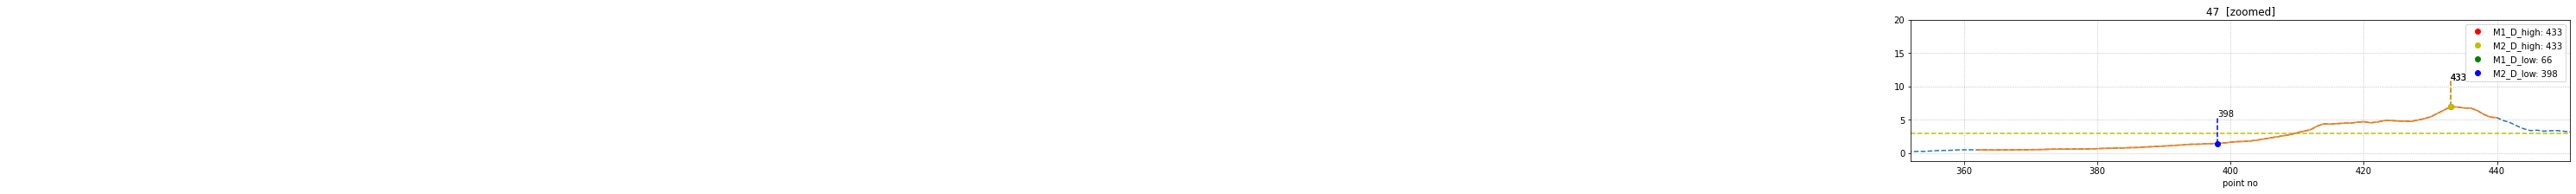

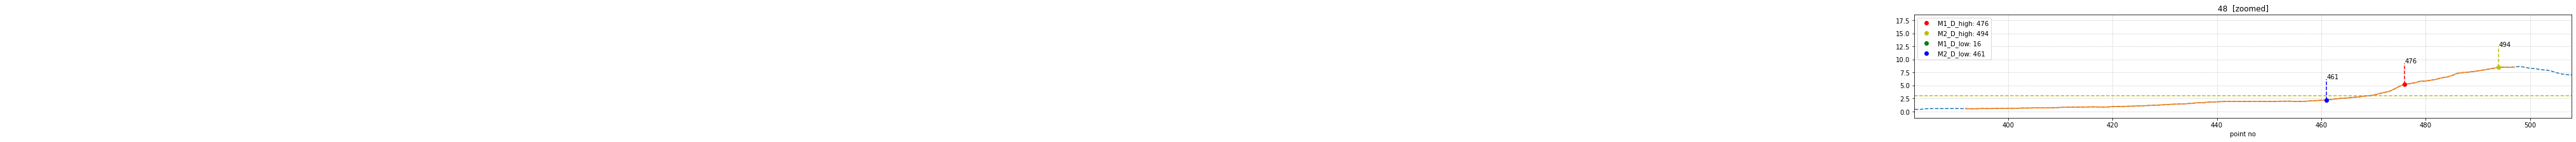

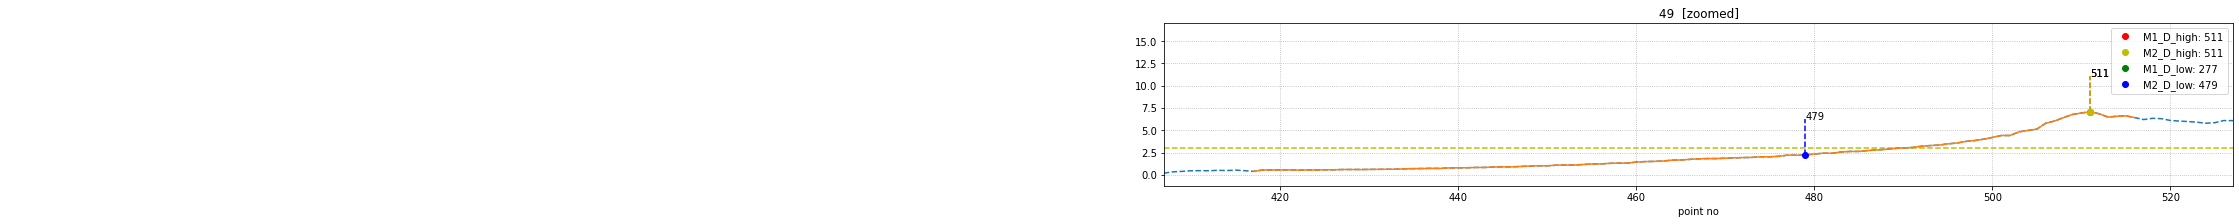

In [20]:
plt.rcParams["figure.figsize"] = (20,3)
for idx in range(len(profiles)):
    profile_id = int(re.findall('\d{1,4}', profile_names[idx])[0])
    draw_profile_features(
        title=profile_id,
        axlines=[3], # threshold
        features=['elevation'],
        points=csv_results.loc[csv_results['profile_id'] == profile_id],
        profile=profiles[idx],
        begin_no=0,
        end_no=len(profiles[idx]) - 1,
        zoom=True,
        save=True,
        show=True)